## Load the environment

---

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from agent import DLQAgent
from datetime import datetime
import sys
import json

Using TensorFlow backend.


In [2]:
env = UnityEnvironment(file_name="../Banana.app")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Create the DLQ agent

---

In [3]:
#TODO: find a more readable way to declare the config
class Config:
    def __init__(self):
        self.num_episodes = 500
        self.gamma = 0.99
        self.epsilon_start = 0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0
        self.tau = 1e-3
        self.memory_size = int(1e5)
        self.min_prioritization = 1e-4
        self.prioritization_exponent = 0
        self.prioritization_importance_sampling_start = 0
        self.prioritization_importance_sampling_end = 0
        self.batch_size = 64
        self.update_every = 10
        self.mlp_layers = (200, 150)
        self.learning_rate = 5e-6
        
        
    def as_dict(self):
        return self.__dict__

env_info = env.reset(train_mode=True)[brain_name]
dlq_agent = DLQAgent(Config(), brain.vector_action_space_size, len(env_info.vector_observations[0]))

## Train the agent

---

In [4]:
def rolling_avg_scores(scores, window):
    if len(scores) <= window:
        return [np.mean(scores)]
    else:
        return [np.mean(scores[x:x+window]) for x in range(len(scores) - window + 1)]

def run(env, brain_name, agent, num_episodes=1500):
    start_time = datetime.utcnow()
    scores = []
    health_checks = []
    for i_episode in range(num_episodes):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        while True:
            action = agent.act(state)                      # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score
            agent.step(
                state, action, next_state, reward, done)   # update the agent
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                scores.append(score)
                break
        health_check = agent.health_check()
        health_checks.append(health_check)
        model1_loss, memory_max_prioritization, memory_size = health_check
        print("\rEpisode %d/%d | Max Average Score: %.2f | Model 1 loss: %.2f | Memory max prioritization: %.2f | Memory size: %d" % (
            i_episode,
            num_episodes,
            max(rolling_avg_scores(scores, 20)),
            model1_loss,
            memory_max_prioritization,
            memory_size), end="")
        sys.stdout.flush()
    end_time = datetime.utcnow()
    return scores, end_time - start_time, health_checks

In [5]:
scores, run_timing, health_checks = run(env, brain_name, dlq_agent, num_episodes=Config().num_episodes)
with open('training_log.txt', 'a') as file:
    file.write("Training run on %s \n" % datetime.utcnow().isoformat())
    file.write("Lasted %dmin%d \n" % (run_timing.seconds // 60, run_timing.seconds % 60))
    file.write(json.dumps(Config().as_dict(), indent=2))
    file.write("\nMax average score: %f\n\n" % max(rolling_avg_scores(scores, 20)))

Episode 499/500 | Max Average Score: 0.45 | Model 1 loss: 0.29 | Memory max prioritization: 1.00 | Memory size: 100009

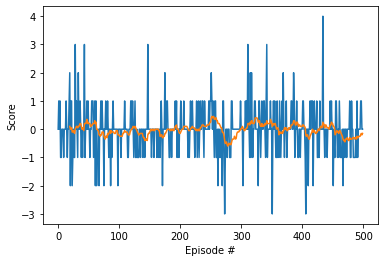

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(19, len(scores)), rolling_avg_scores(scores, 20))
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

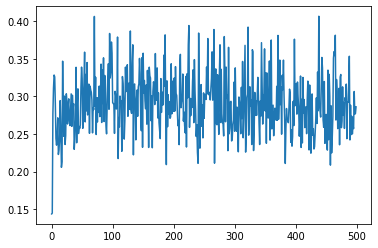

In [7]:
from operator import itemgetter
losses = [x for x in map(itemgetter(0), health_checks)]
plt.plot(np.arange(len(losses)), losses)
plt.show()